# Intervalos en Julia

# [1]

#### (i) Define un tipo compósito de Julia `Intervalo` para representar un intervalo de dos números reales, que incluya redondeo dirigido. Por el momento supongamos que todos los elementos serán de tipo BigFloat.  Para ello, deberás definir constructores que acepten cadenas y/o números.

In [63]:
type Intervalo
    a::BigFloat
    b::BigFloat
    
    Intervalo(a::BigFloat,b::BigFloat) = ( a>=b ? new(b,a) : new(a,b))
end

function redonUP(x)
    with_rounding(BigFloat,RoundUp) do 
        BigFloat(x) 
    end
end

function redonDOWN(x)
    with_rounding(BigFloat,RoundDown) do 
        BigFloat(x) 
    end
end

Intervalo(a,b)=Intervalo(redonDOWN(a),redonUP(b)) #Con esta definición puedo usar como argumento cadenas de caracteres
                                                    # tomando en cuenta el redondeo
Intervalo(a)=Intervalo(a,a)

Intervalo (constructor with 3 methods)

In [64]:
methods(Intervalo)

# 3 methods for generic function "Intervalo":
Intervalo(a::BigFloat,b::BigFloat) at In[63]:5
Intervalo(a,b) at In[63]:20
Intervalo(a) at In[63]:22

In [65]:
Intervalo("0.1","0.1")

Intervalo(9.999999999999999999999999999999999999999999999999999999999999999999999999999914e-02 with 256 bits of precision,1.000000000000000000000000000000000000000000000000000000000000000000000000000002e-01 with 256 bits of precision)

In [66]:
import Base.show
show(io::IO, a::Intervalo) = print(io::IO, "[$(a.a),
$(a.b)]")
Intervalo("0.1","0.1")

[9.999999999999999999999999999999999999999999999999999999999999999999999999999914e-02,
1.000000000000000000000000000000000000000000000000000000000000000000000000000002e-01]

#### (ii) Implementa las operaciones básicas sobre intervalos.

Para implementar operaciones que incluyan el redondeo, hay que notar lo siguiente:

En la definición de la suma de BigFloat's de Julia hay un redondeo por default, para mostrarlo observemos el siguiente ejemplo:

In [67]:
println(redonDOWN("0.2"))
println(redonDOWN("1.0"))
println(redonDOWN(redonDOWN("1.0")+redonDOWN("0.2")))
println(redonDOWN("1.2"))

1.999999999999999999999999999999999999999999999999999999999999999999999999999983e-01
1e+00
1.200000000000000000000000000000000000000000000000000000000000000000000000000007e+00
1.19999999999999999999999999999999999999999999999999999999999999999999999999999e+00


Nosotros sabemos que la suma de $1.0_\mathbb{R} + 0.2_\mathbb{R} =1.2_\mathbb{R}$ de los cuales solo $1.0_\mathbb{R}$ tiene representación 'exacta' como flotante (subíndice $\mathbb{R}$ es para indicar que es el número real). Con lo anterior vemos que aunque `redonDOWN`("$0.2$")$<0.2_\mathbb{R}$  y que `redonDOWN`("$1.0$")$=1_\mathbb{R}$ la suma 

`redonDOWN`("$0.2$")$+$ `redonDOWN`("$1.0$")$>1.2_\mathbb{R}$. 

Lo que necesitamos para que la suma sea menor (o igual) que $1.2_\mathbb{R}$ es obligar a usar el redondeo deseado al momento de realizar la suma:

In [68]:
with_rounding(BigFloat,RoundDown) do 
    redonDOWN("1.0")+redonDOWN("0.2")
end

1.19999999999999999999999999999999999999999999999999999999999999999999999999999e+00 with 256 bits of precision

Que es justamente `redonDOWN`("$1.2$")

Para asegurarnos que esto ocurra con todas las operaciones entre intervalos, voy a incluir en la definición las siguientes funciones:

In [69]:
function redonUP(f::Function,x,y)
    with_rounding(BigFloat,RoundUp) do 
        f(BigFloat(x),BigFloat(y))
    end
end

function redonDOWN(f::Function,x,y)
    with_rounding(BigFloat,RoundDown) do 
        f(BigFloat(x),BigFloat(y))
    end
end

redonDOWN (generic function with 2 methods)

##### Ahora sí podemos implementar el código:

#### (iii) Limpia tu código para reducir la repetición de código, al sacar cada vez código en común a una función por separado.

In [70]:
function definidor!(f::Function)  #función que define operaciones entre intervalos
    if f!=^
        f(x::Intervalo,y::Intervalo) = (f==/ && y.a<0.0 && y.b>0.0) ? error("El intervalo divisor no puede contener al cero") :
            Intervalo(min(redonDOWN(f,x.a,y.a),redonDOWN(f,x.b,y.b),redonDOWN(f,x.a,y.b),redonDOWN(f,x.b,y.a),
                redonUP(f,x.a,y.a),redonUP(f,x.b,y.b),redonUP(f,x.a,y.b),redonUP(f,x.b,y.a)),
            max(redonDOWN(f,x.a,y.a),redonDOWN(f,x.b,y.b),redonDOWN(f,x.a,y.b),redonDOWN(f,x.b,y.a),
                redonUP(f,x.a,y.a),redonUP(f,x.b,y.b),redonUP(f,x.a,y.b),redonUP(f,x.b,y.a)))
        f(x::Intervalo,y::Number) = (f==/ && (redonDOWN(y)==0.0 || redonUP(y)==0.0)) ?
            error("No puedo dividir un intervalo entre cero") :
            f(x,Intervalo(y))
        f(x::Intervalo,y::ASCIIString) = (f==/ && (redonDOWN(y)==0.0 || redonUP(y)==0.0)) ?
            error("No puedo dividir un intervalo entre cero") :
            f(x,Intervalo(y))
        f(y::Number,x::Intervalo) = (f==/ && x.a<0.0 && x.b>0.0) ? error("El intervalo divisor no puede contener al cero") :
            f(Intervalo(y),x)
        f(y::ASCIIString,x::Intervalo) = (f==/ && x.a<0.0 && x.b>0.0) ? error("El intervalo divisor no puede contener al cero") :
            f(Intervalo(y),x)
     else
        f(x::Intervalo,y::Integer)= y<0 ? "1"/f(x,-y) :
            (y==0 ? Intervalo("1") :
            (x.a<0.0 && x.b>0.0 ? Intervalo(min(0.0,redonDOWN(f,x.a,y),redonDOWN(f,x.b,y)),max(redonDOWN(f,x.a,y),redonDOWN(f,x.b,y))) :
            Intervalo(min(redonDOWN(f,x.a,y),redonDOWN(f,x.b,y)),max(redonDOWN(f,x.a,y),redonDOWN(f,x.b,y)))))       
    end
end

definidor! (generic function with 1 method)

In [71]:
definidor!(+)
definidor!(-)
-(x::Intervalo) = x * -1
definidor!(*)
definidor!(/)
definidor!(^)
==(x::Intervalo,y::Intervalo) = (x.a==y.a && x.b==y.b) ? true : false
import Base.in
in(x,y::Intervalo) = (y.a<=Intervalo(x).a && Intervalo(x).b<=y.b) ? true : false

in (generic function with 23 methods)

Algunas pruebas:

In [80]:
in("0.1",Intervalo("0.1"))

true

In [329]:
a=Intervalo(1,"1.0")
b=Intervalo("0.2","0.4")
c=1//3
println("a+b=",a+b)
println("c+a=",c+a)
println("b-a=",b-a)
println("a-c=",a-c)
println("a*b=",a*b)
println("a*c=",a*c)
println("a/b=",a/b)
println("a/c=",a/c)
println("a^2=",a^2)
println("b^-1=",b^-1)

a+b=[1.19999999999999999999999999999999999999999999999999999999999999999999999999999e+00,
1.400000000000000000000000000000000000000000000000000000000000000000000000000014e+00]
c+a=[1.333333333333333333333333333333333333333333333333333333333333333333333333333322e+00,
1.333333333333333333333333333333333333333333333333333333333333333333333333333339e+00]
b-a=[-8.000000000000000000000000000000000000000000000000000000000000000000000000000017e-01,
-5.999999999999999999999999999999999999999999999999999999999999999999999999999948e-01]
a-c=[6.666666666666666666666666666666666666666666666666666666666666666666666666666609e-01,
6.666666666666666666666666666666666666666666666666666666666666666666666666666695e-01]
a*b=[1.999999999999999999999999999999999999999999999999999999999999999999999999999983e-01,
4.000000000000000000000000000000000000000000000000000000000000000000000000000009e-01]
a*c=[3.333333333333333333333333333333333333333333333333333333333333333333333333333305e-01,
3.333333333333333333333

In [331]:
a=Intervalo("-1.0","3.0")
b=Intervalo("12","13")
c="4"                      #Las constantes a, b, c pueden definirse con o sin comillas
println("a+b=",a+b)
println("c+a=",c+a)
println("b-a=",b-a)
println("a-c=",a-c)
println("a*b=",a*b)
println("a*c=",a*c)
println("a/b=",a/b)
println("a/c=",a/c)
println("a^2=",a^2)
println("b^-1=",b^-1)

a+b=[1.1e+01,
1.6e+01]
c+a=[3e+00,
7e+00]
b-a=[9e+00,
1.4e+01]
a-c=[-5e+00,
-1e+00]
a*b=[-1.3e+01,
3.9e+01]
a*c=[-4e+00,
1.2e+01]
a/b=[-8.333333333333333333333333333333333333333333333333333333333333333333333333333369e-02,
2.5e-01]
a/c=[-2.5e-01,
7.5e-01]
a^2=[0e+00,
9e+00]
b^-1=[7.692307692307692307692307692307692307692307692307692307692307692307692307692216e-02,
8.333333333333333333333333333333333333333333333333333333333333333333333333333369e-02]


In [14]:
Intervalo("2.5",5)==Intervalo(2.5,5.0)

true

In [15]:
Intervalo(0.0,0.1)==Intervalo(0.0,"0.1")

false

# [2]

#### Haz un módulo de Julia llamado `Intervalos` en un archivo `intervalos.jl`, que contiene todas las definiciones anteriores

Para agregar la carpeta de MisModulos a LOAD_PATH de modo que module busque en esa carpeta hago

`push!(LOAD_PATH, "/home/santiago/Documentos/Escuela-maestría/1er-semestre/Física-computacional/Clase/MisModulos")`

Para no tener que hacer esto cada vez, lo que hice fue crear el archivo `~/.juliarc.jl` que contiene la instrucción anterior, de modo que ahora LOAD_PATH siempre contendrá esta opción de búsqueda

In [4]:
Intervalo

LoadError: Intervalo not defined
while loading In[4], in expression starting on line 1

In [4]:
using Intervalos

In [6]:
Intervalo

Intervalo (constructor with 3 methods)

In [4]:
Intervalo(2)+Intervalo("10")

[1.2e+01,
1.2e+01]

# [3]

#### (i) Escribe tests ("pruebas") usando FactCheck.jl.

In [82]:
using Intervalos,FactCheck

In [89]:
facts("Probando tipo Intervalo") do
    interv1=Intervalo("0.1")
    @fact typeof(interv1.a) => BigFloat 
    @fact Intervalo("4","3") => Intervalo(3,4)
    @fact -Intervalo("4","3") => Intervalo(-4.0,-3.0)
    @fact interv1 => Intervalo(1//10) #verifico que convierta cadena de caracteres y racionales
    interv2=Intervalo("0.1",10//3)
    numero1=with_rounding(BigFloat,RoundDown) do
            BigFloat("0.1")
        end
    numero2=with_rounding(BigFloat,RoundUp) do
            BigFloat(10//3)
        end
    @fact interv2.a => numero1 #verifico que haga bien el redondeo
    @fact interv2.b => numero2 #verifico que haga bien el redondeo
    @fact Intervalo("0.2").a => less_than(Intervalo("0.2").b) #verifico que haga bien el redondeo
    @fact in("0.1",Intervalo("0.1")) => true
end

facts("Probando operaciones entre intervalos")do
    interv1=Intervalo("-1.0","3.0")
    interv2=Intervalo("12","13")
    @fact interv1+interv2 => Intervalo("11","16") #verifico operaciones entre intervalos "enteros"
    @fact interv1-interv2 => Intervalo("-14","-9")
    @fact interv1*interv2 => Intervalo("-13","39")
    @fact interv1/interv2 => Intervalo(-1//12,3//12)
    numero1=4
    @fact interv1+numero1 => Intervalo("3","7") #verifico operaciones entre intervalos y números
    @fact interv1-numero1 => Intervalo("-5","-1")
    @fact interv1*numero1 => Intervalo("-4","12")
    @fact interv2/numero1 => Intervalo("3",13//4)
    @fact numero1/interv2 => Intervalo(4//13,4//12)
    @fact interv1^numero1 => Intervalo("0","81")
    @fact interv2^-1 => 1/interv2
    interv3=Intervalo("1","4")
    interv4=Intervalo("0.2","3")
    numero2=with_rounding(BigFloat,RoundDown) do
            BigFloat("1.2")
        end
    numero3=10//3
    numero4=with_rounding(BigFloat,RoundUp) do
            BigFloat(2//3)
        end
    @fact (interv3+interv4).a => less_than_or_equal(numero2) #pruebo redondeo en operaciones
    @fact (interv3-numero3).b => greater_than_or_equal(numero4)    
end

Probando tipo Intervalo
6 facts verified.
Probando operaciones entre intervalos
13 facts verified.


delayed_handler (generic function with 4 methods)

# Operaciones con intervalos

# [4]

#### Utiliza tu código para rehacer el cálculo de π del notebook 5. Ahora, ¡deberá ser mucho más fácil!

En el notebook 5 vimos que 

\begin{equation}
S=\sum_{n=1}^{\infty} \frac{1}{n^2} = \frac{\pi^2}{6}
\end{equation}

Además vimos que esa suma se podía acotar:

\begin{equation}
    \left(∑_{n=1}^N \frac{1}{n^2}\right)_{\downarrow} + \frac{1}{N+1} < S=\frac{\pi^2}{6} < \left(∑_{n=1}^N \frac{1}{n^2}\right)_{\uparrow} + \frac{1}{N}
\end{equation}

Donde $\left(...\right)_{\downarrow (\uparrow)}$ indica que el cálculo del parentesis se hace con redondeo hacia abajo (arriba) 

In [41]:
function calculaPI(N::Int64)
    suma=Intervalo("0")
    for i=1:N
        suma+=1/((Intervalo(N-i+1))^2)
    end
    limites=Intervalo((suma+(1/(Intervalo(N)+1))).a,    (suma+(1/(Intervalo(N)))).b)
end

calculaPI (generic function with 1 method)

In [45]:
calculaPI(100000)

[1.644934066798227269795748603311691865647421330811550342589886233711542834938415e+00,
1.644934066898226269805748503312691855647521329811560342489887233701542934937578e+00]

In [32]:
(π^2)/6

1.6449340668482264

#### ¿Cuál es la diferencia entre el cálculo mediante intervalos y el cálculo original que hicimos?

Si comparo los valores que se obtienen para distintas N's los resultados son los mismos en el notebook 5 y ahora. Sin embargo en este método con intervalos la cantidad de código utilizada fue mucho menor, ya que nuestro tipo `Intervalo` (con sus respectivas operaciones) ya incluye la idea de acotar resultados.

# [5]

#### (i) Define la potencia para intervalos.

Ya lo he definido

#### (ii) Para el intervalo $X=[−1,1]$, calcula $X⋅X$ y $X^2$ (donde $⋅$ denota la multiplicación de intervalos). ¿Qué observas?

In [97]:
inter1=Intervalo("-1.0","1.0")
println(inter1*inter1)
println(inter1^2)

[-1e+00,
1e+00]
[0e+00,
1e+00]


Que el producto de un intervalo por él mismo no es lo mismo que elevarlo al cuadrado

#### (iii) Calcula $[−1,1]⋅([−1,0]+[3,4])$ y $[−1,1]⋅[−1,0]+[−1,1]⋅[3,4]$. ¿Qué observas?

In [101]:
inter2=Intervalo("-1.0","0")
inter3=Intervalo("3.0","4.0")
println(inter1*(inter2+inter3))
println((inter1*inter2)+(inter1*inter3))

[-4e+00,
4e+00]
[-5e+00,
5e+00]


Que el producto no es distributivo

Notemos que en ambos casos la diferencia radica en que un intervalo representa `UN` número que está en ese intervalo, por lo que tomar dos veces el mismo intervalo no implica que se tome el mismo número. Hay que tener cuidado en esta diferencia sutil a la hora de realizar cálculos con intervalos.

# [6]

#### (i) Define una función polinomial $p_1(x):=(x−1)(x−2)$.

In [3]:
pol1(x)=(x-1)*(x-2)

pol1 (generic function with 1 method)

#### (ii) ¿Cómo se puede mandar a $p_1$ un intervalo como argumento?

In [287]:
interv1=Intervalo("5","8")
pol1(interv1)

[1.2e+01,
4.2e+01]

#### (iii) ¿Qué representa el resultado?

En el caso particular de tomar $[5,8]$, el resultado representa los posibles valores que se pueden obtener si se toma algún número entre $5$ y $8$, restarle uno y multiplicarlo por `él mismo` menos 2.

Sin embargo este no es el caso siempre, tomemos por ejemplo el intervalo $[1.25,1.75]$. Nosotros sabemos que el resultado de eso debería ser $[-0.25,-0.1875]$ sin embargo el resultado que se obtiene es distinto:

In [288]:
interv2=Intervalo("1.25","1.75")
pol1(interv2)

[-5.625e-01,
-6.25e-02]

La razón es la misma que en el ejercicio [5]: al definir las operaciones con intervalos como las definimos, no podemos definir que dos intervalos iguales representen el mismo número. En este ejemplo el valor mínimo de $(x−1)(x−2)$ ocurre cuando tomas la primera $x=1.75$ y la segunda $x=1.25$, lo cual no debe ocurrir ya que $x$ representa el mismo número.

Otra observación es que como operamos con los extremos de los intervalos, no podemos obtener el mínimo verdadero $-0.25$ ya que corresponde a tomar $pol1(1.5)$

#### (iv) Juega con distintos intervalos como entrada y dibuja los resultados. ¿Qué observas?

In [23]:
using PyPlot

INFO: Loading help data...


In [406]:
function graficador(a,b,f::Function)
    puntosX=(-5:0.125:8)
    puntosY=similar(puntosX)
    for i=1:length(puntosX)
        puntosY[i]=f(puntosX[i])
    end
    
    ptsX=(a:0.125:b)
    ptsY=similar(ptsX)
    for i=1:length(ptsX)
        ptsY[i]=f(ptsX[i])
    end
    
    polY=f(Intervalo(a,b))
    
    PyPlot.plot(puntosX,puntosY,"r",linewidth=1)
    PyPlot.plot(ptsX, ptsY, "b", linewidth=2.0)
    
    PyPlot.plot((a-1)*[1,1],float64([polY.a,polY.b]), "black", linewidth=2.0)
    PyPlot.plot([a-1,a],float64(polY.a)*[1,1],"black", linewidth=1.0, linestyle="--")
    PyPlot.plot([a-1,a],float64(polY.b)*[1,1], "black", linewidth=1.0, linestyle="--")
    
    PyPlot.plot([a,b],(float64(polY.a)-1)*[1,1], "black", linewidth=2.0)
    PyPlot.plot([a,a],[float64(polY.a)-1,float64(polY.a)], "black", linewidth=1.0, linestyle="--")
    PyPlot.plot([b,b],[float64(polY.a)-1,float64(polY.a)], "black", linewidth=1.0, linestyle="--")
    
    PyPlot.xlim(min(-1,a-1),max(0,b+1))
    PyPlot.ylim(min(-1,float64(polY.a)-1.5),max(float64(polY.a),float64(polY.b),f(a),f(b))+1);

    PyPlot.fill_between([a,b],float64(polY.a),float64(polY.b),color="lightgray")
    PyPlot.suptitle("La sombra gris es la zona calculada con intervalo [$a,$b]")
end

graficador (generic function with 2 methods)

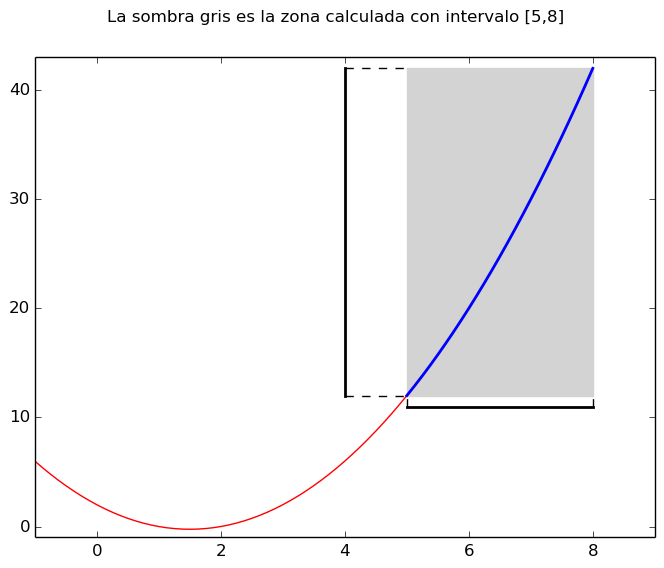

In [377]:
graficador(5,8,pol1);

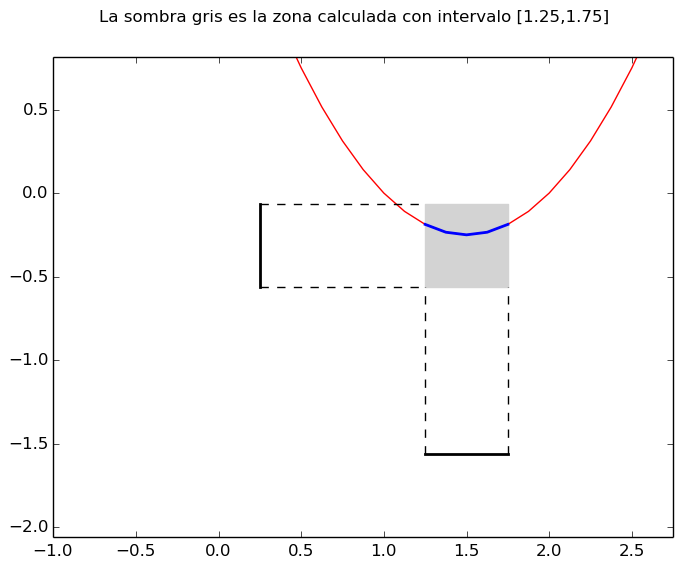

In [327]:
graficador(1.25,1.75,pol1);

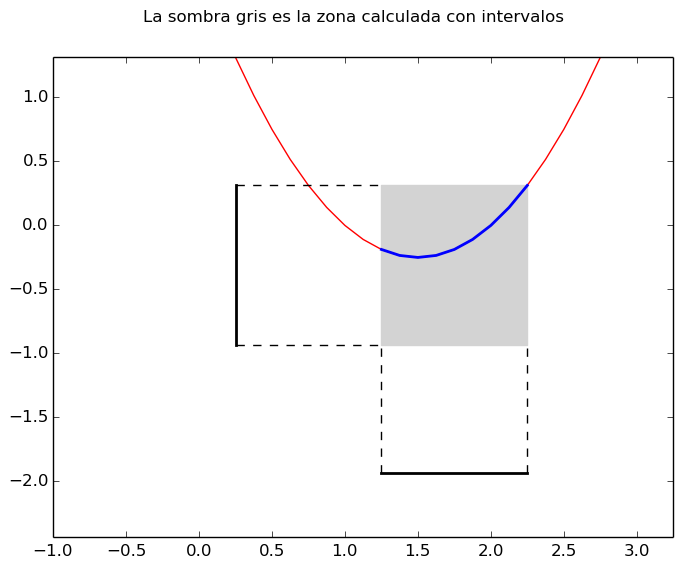

In [297]:
graficador(1.25,2.25,pol1);

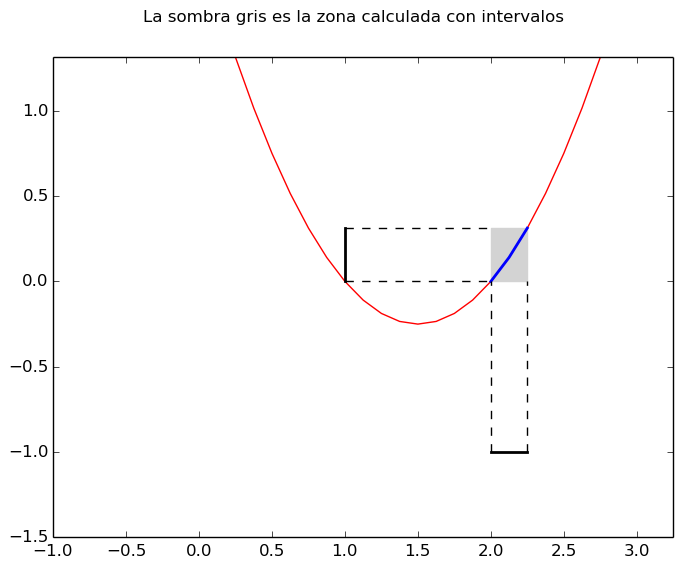

In [298]:
graficador(2,2.25,pol1);

Lo que observo es que cuando un intevalo que contiene valores entre $[1,2]$ se 'mete' en la función `pol1`$(x)$, el intervalo resultante es mayor que el intervalo donde realmente están los valores posibles de `pol1`$(x)$

#### (v) ¿Qué pasa si reescribes $p_1$ en una forma equivalente? ¿En otra forma equivalente?

Si reescribo $p_1$ como $p_2= x^2 - 3x + 2$ entonces:

In [299]:
pol2(x)=x^2 - 3*x + 2

pol2 (generic function with 1 method)

In [300]:
pol2(interv1)

[3e+00,
5.1e+01]

In [301]:
pol2(interv2)

[-1.6875e+00,
1.3125e+00]

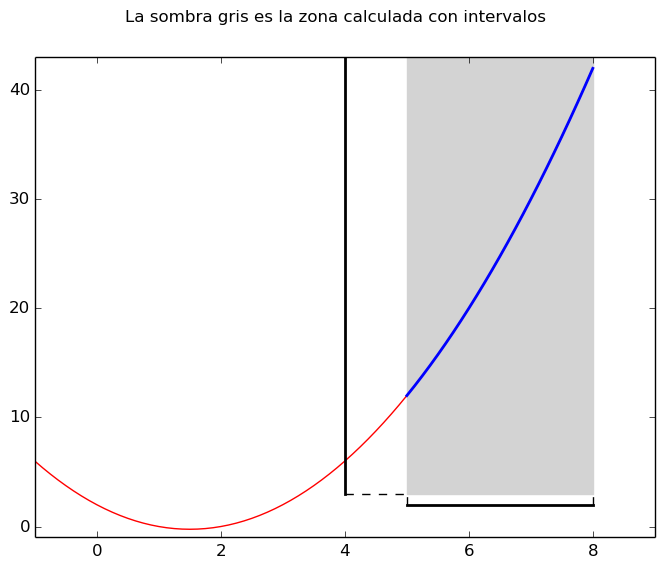

In [302]:
graficador(5,8,pol2);

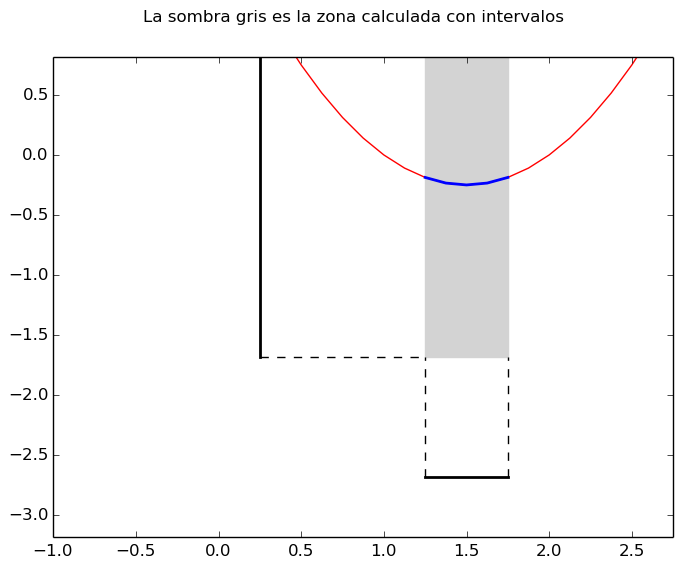

In [315]:
graficador(1.25,1.75,pol2);

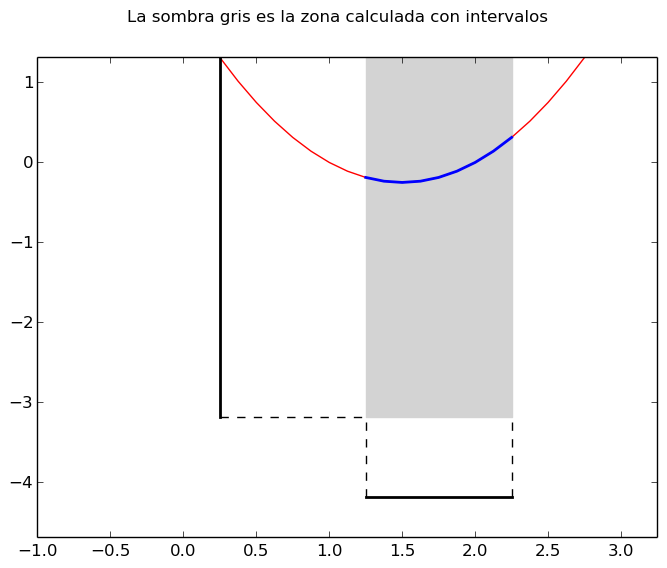

In [316]:
graficador(1.25,2.25,pol2);

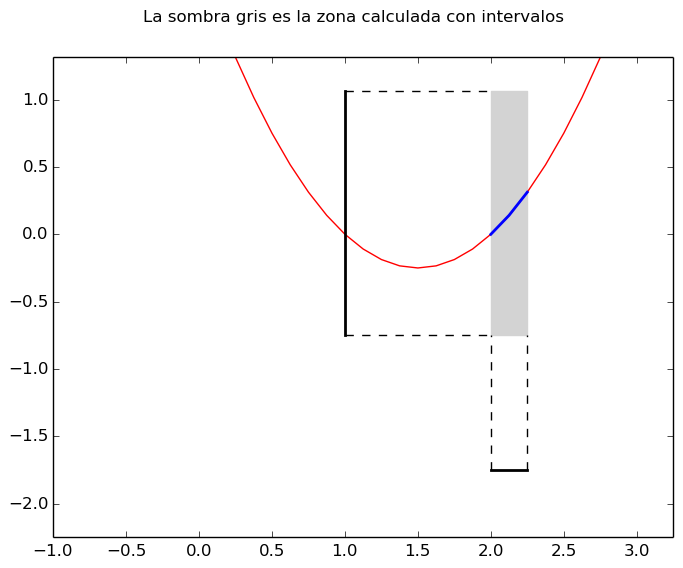

In [317]:
graficador(2,2.25,pol2);

Por lo tanto: Si expando el polinomio, el intervalo que obtengo es peor

In [321]:
pol2(Intervalo(2,2.25))
pol1(1.5)

-0.25

#### (vi) Pensando en este ejemplo de polinomios, ¿para qué nos sirven los intervalos?

Nos sirven para acotar el resultado, es decir operando con intervalos podemos conocer un intervalo que contiene la respuesta. La cosa es que ese intervalo puede ser mayor que el rango (o imagen) de una función.

Por ejemplo, en el caso del polinomio anterior, obtuvimos en ciertos casos intervalos que iniciaban por debajo de $-0.25$, aún cuando nosotros sabemos que el polinomio no puede tomar valores menores a $-0.25$.

Podríamos entonces realizar mejor el cálculo tomando esto en cuenta:

Supongamos que el intervalo resultante es `Intervalo(a,b)` y que el rango o imagen de la función es `Intervalo(minf,maxf)`

Entonces nos conviene decir que el resultado es:

Intervalo(max(a,minf),min(b,maxf))

# [7]

#### (i) Haz una implementación de tu idea de la pregunta [6].

Podemos entonces definir como actua la función `pol1`$(x)$ de manera especial para intervalos de la siguiente manera:

In [378]:
fmin=-0.25
fmax=inf(BigFloat)
pol1real(x::Intervalo)= Intervalo( max(pol1(x).a,fmin)  , min(pol1(x).b,fmax) )
pol1real(x::Number)=pol1(x)

pol1real (generic function with 3 methods)

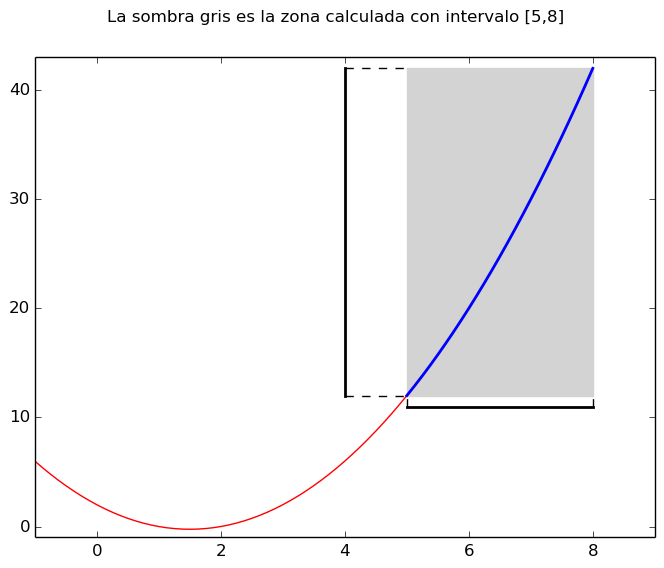

In [379]:
graficador(5,8,pol1real);

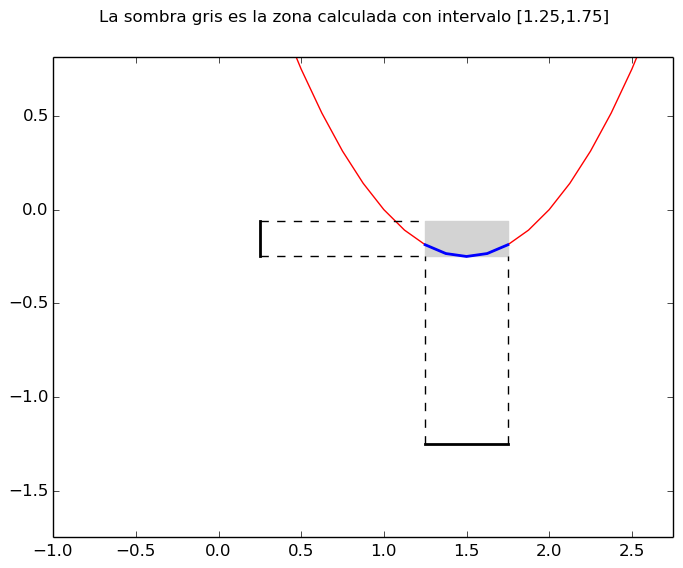

In [380]:
graficador(1.25,1.75,pol1real);

Con esto, el resultado de la cota superior es mucho mejor

#### (ii) Pruébalo con $p_2(x):=x^2−2$.

In [398]:
pol2(x)=x^2 - 2

pol2 (generic function with 1 method)

In [399]:
fmin=-2
fmax=inf(BigFloat)
pol2real(x::Intervalo)= Intervalo( max(pol2(x).a,fmin)  , min(pol2(x).b,fmax) )
pol2real(x::Number)=pol2(x)

pol2real (generic function with 2 methods)

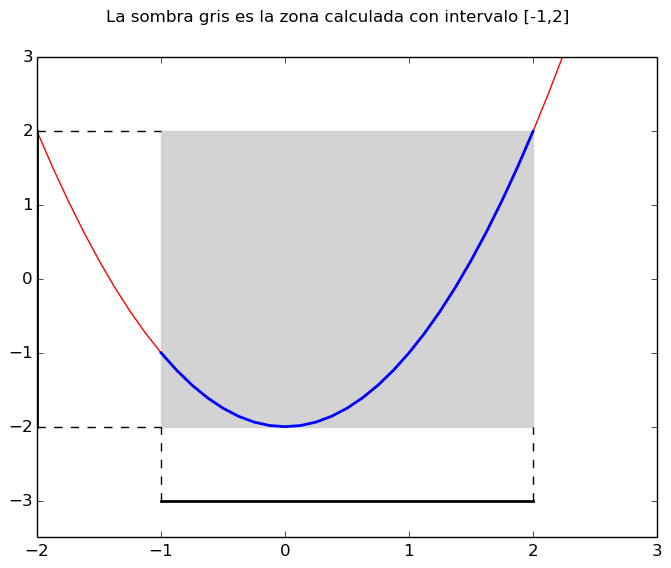

In [400]:
graficador(-1,2,pol2real);

#### (iii) Pruébalo con otros polinomios.

In [401]:
pol3(x)=(x-2)*x
fmin=-1
fmax=inf(BigFloat)
pol3real(x::Intervalo)= Intervalo( max(pol3(x).a,fmin)  , min(pol3(x).b,fmax) )
pol3real(x::Number)=pol3(x)

pol3real (generic function with 2 methods)

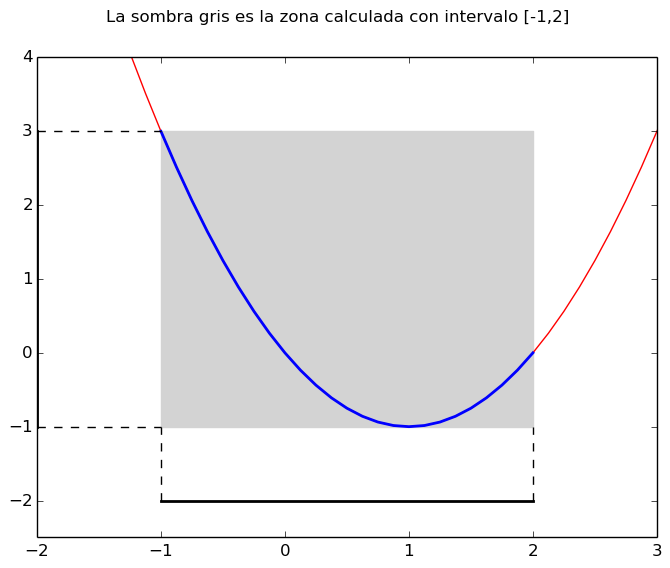

In [402]:
graficador(-1,2,pol3real);

In [403]:
pol4(x)=-(x-2)*x
fmin=-inf(BigFloat)
fmax=1
pol4real(x::Intervalo)= Intervalo( max(pol4(x).a,fmin)  , min(pol4(x).b,fmax) )
pol4real(x::Number)=pol4(x)

pol4real (generic function with 2 methods)

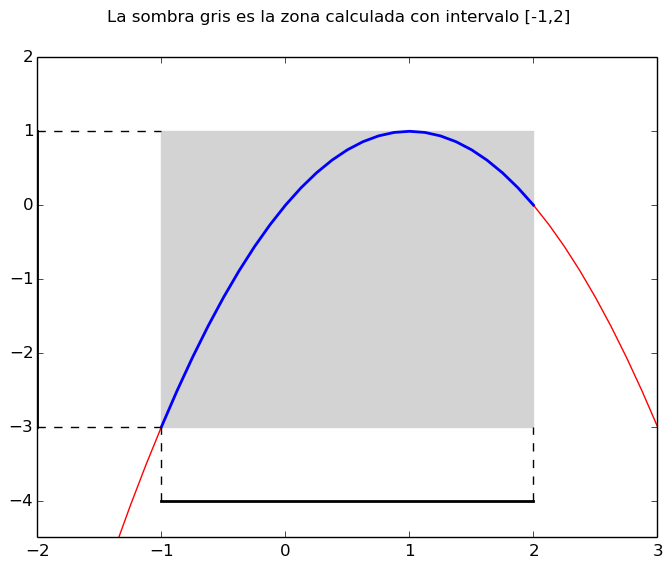

In [407]:
graficador(-1,2,pol4real);